In [32]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [33]:
K=6
D=10
N=85
suff='MAX85'

In [34]:
with open(f'pkl/emoprox2_dataset_timeseries+inputs_{suff}.pkl','rb') as f:
    df = pickle.load(f)

In [35]:
with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{122}subjs_2.pkl','rb') as f:
    model,q,elbos,subj_list = pickle.load(f)
# df = df[df['pid'].isin(subj_list)].reset_index()

resampled_df = []
for pid in subj_list:
    resampled_df.append(df[df["pid"] == pid])
resampled_df = pd.concat(resampled_df).reset_index().drop("index", axis=1)
df = resampled_df

In [36]:
df['continuous_states'] = [None]*df.shape[0]
df['discrete_states'] =[None]*df.shape[0]
hrflag=3
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df.loc[idx_row]['timeseries']
    x = q.mean_continuous_states[idx_row]
    z = model.most_likely_states(x,y,input=input)
    df.at[idx_row,'continuous_states'] = x
    df.at[idx_row,'discrete_states'] = z
    prox = df.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df.at[idx_row,'proximity'] = prox

In [37]:
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
hrf_shift=3
def get_p_state_giv_stimulus(df, shuffle_z:bool=False):

    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1
    count_mats = np.zeros((K,nprox*ndir))
    # populate state stimulus matrix
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]['discrete_states']) # sequence of discrete states
        censor = df.loc[idx_row]['censor'][:,0]

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z: z = np.roll(z,shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]['proximity'], bins=prox_bins)
        dir = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift>0:
            prox = np.roll(prox,shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir,shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]
            censor = censor[:-hrf_shift]

        # make sure lengths are consistent
        assert len(z)==len(prox)
        assert len(z)==len(dir)

        for prox_t,dir_t,z_t,use_t in zip(prox,dir,z,censor):
            # if apply_censor:
            #     if use_t==1: count_mats[z_t,prox_t+nprox*dir_t] += 1
            # else:
            count_mats[z_t,(nprox*ndir-1)*dir_t+((-1)**dir_t)*prox_t] += 1
            
    count_mats /= np.expand_dims(count_mats.sum(axis=0),axis=0)
    
    return count_mats

In [38]:
from scipy.stats import ttest_1samp
true_mat = get_p_state_giv_stimulus(df, shuffle_z=False)
num_null = 1000
null_mats = np.zeros((num_null,K,nprox*ndir))
for i in tqdm(range(num_null)):
    null_mats[i,:,:] = get_p_state_giv_stimulus(df,shuffle_z=True)


100%|██████████| 1000/1000 [09:28<00:00,  1.76it/s]


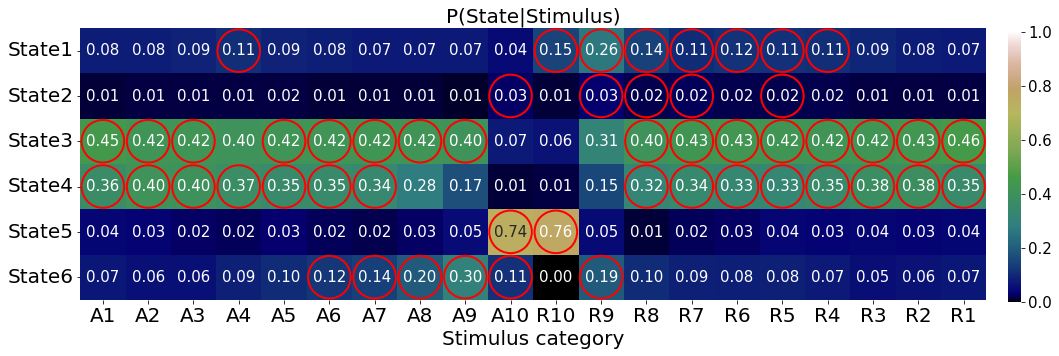

In [39]:
pvals = np.zeros_like(true_mat)
for i in range(K):
    for j in range(nprox*ndir):
        pvals[i,j] = ttest_1samp(null_mats[:,i,j],true_mat[i,j],alternative='less').pvalue
        # pvals[i,j] = (null_mats[:,i,j]>true_mat[i,j]).sum()/num_null

xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
sns.heatmap(
    true_mat,
    annot=true_mat, fmt='.2f', annot_kws={'size': 15},
    cmap="gist_earth",
    vmin=0,vmax=1,
    ax=ax,
    cbar=True,
    square=True,
)
for i in range(K):
    for j in range(nprox*ndir):
        if pvals[i,j] < 0.05:#/(nprox*ndir*K):
            ax.add_patch(
                patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='red',facecolor='none')
            )
ax.set_title(r'P(State|Stimulus)',fontsize=20) 
_ = ax.set_yticklabels([f'State{i}' for i in range(1,K+1)], fontsize=20, rotation=0)
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
_ = ax.set_xlabel('Stimulus category',fontsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_yticks(np.arange(6)/5)
cbar.ax.set_position([0.755,0.12,1,0.75])

In [9]:
import rle
import random

def get_trans_mat(df,shuffle_z:bool=False):
    PI = np.zeros((K,K))
    for z in df['discrete_states'].values:

        z_perm = z.copy()

        if shuffle_z == True:
            values,counts = rle.encode(z_perm)
            encoding = list(zip(values, counts))
            random.shuffle(encoding)
            values,counts = zip(*encoding)
            z_perm = rle.decode(values=values, counts=counts)

        for st_from,st_to in zip(z_perm[:-1],z_perm[1:]):
            PI[st_from,st_to] += 1
    PI = PI / np.expand_dims(PI.sum(axis=1),axis=1)
    return PI

from scipy.stats import ttest_1samp
true_pi = get_trans_mat(df, shuffle_z=False)
num_null = 1000
null_pi = np.zeros((num_null,K,K))
for i in tqdm(range(num_null)):
    null_pi[i,:,:] = get_trans_mat(df,shuffle_z=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:27<00:00, 36.61it/s]


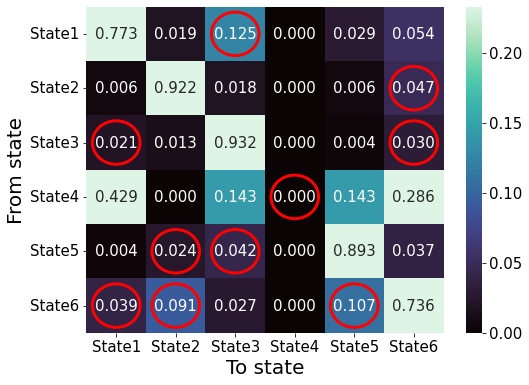

In [10]:
state_names = [f"State{i+1}" for i in range(K)]
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
sns.heatmap(true_pi,annot=True,fmt='0.3f',vmin=0,vmax=true_pi.max()/4,cmap='mako',ax=ax,annot_kws={'size':15})
significant_transitions = []
trans_list = []
for i in range(K):
    for j in range(K):
        pval = (null_pi[:,i,j]>true_pi[i,j]).sum()/num_null
        if pval<0.05/(K*K):
            trans_list.append(f"{i}{j}")
            ax.add_patch(patches.Circle((j+0.5,i+0.5),0.4,linewidth=3, edgecolor='red',facecolor='none'))
            significant_transitions.append(f'{i}{j}')
ax.set_xticklabels(state_names,rotation=0,fontsize=15)
ax.set_yticklabels(state_names,rotation=0,fontsize=15)
ax.set_xlabel('To state',fontsize=20)
ax.set_ylabel('From state',fontsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

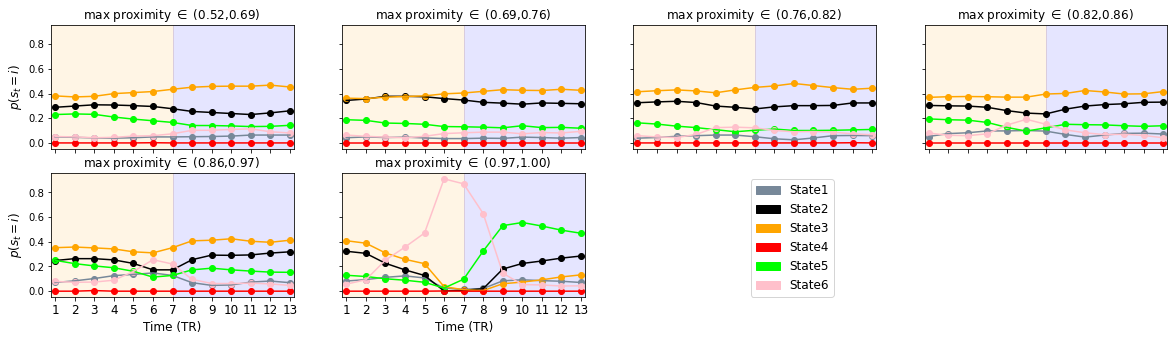

In [11]:
from scipy.signal import argrelextrema
import matplotlib.patches as mpatches
colors = [to_rgba(c) for c in ['lightslategray','black','orange','red','lime','pink','brown','blue']]
state_names = [f'State{i+1}' for i in range(K)]
def find_windows_and_local_maxima(values, censor, window_length, hrf_lag=3):
    """
    Finds windows centered at local maxima in a vector of values, with a given
    censor vector to indicate which indices can be used, and checks that all indices
    in the window are usable according to the censor variable. Returns the local maxima
    values corresponding to the windows.

    Args:
        values (numpy.ndarray): The vector of values.
        censor (numpy.ndarray): The censor vector indicating which indices can be used.
        window_length (int): The desired window length.

    Returns:
        list: A list of tuples representing the windows, where each tuple contains the start
              and end indices of the window.
        list: A list of local maxima values corresponding to the windows.
    """
    # Find the indices of the local maxima in the values vector
    local_maxima_indices = argrelextrema(values, np.greater)[0]

    # Initialize lists to store the windows and local maxima values
    windows = []
    local_maxima = []

    for idx in local_maxima_indices:
        if idx - window_length // 2 + hrf_lag >= 0 and idx + window_length // 2 + hrf_lag < len(values) :
            window_start = idx - window_length // 2 + hrf_lag
            window_end = idx + window_length // 2 + hrf_lag
            windows.append((window_start, window_end))
            local_maxima.append(values[idx])

    return windows, local_maxima

# Example usage:

# Find windows around local maxima and corresponding local maxima values
local_maxima_all = []
windows_all = []
states_all_windows = []
for idx_row in range(df.shape[0]):
    prox = df.loc[idx_row]['proximity']
    censor = df.loc[idx_row]['censor'][:,0]
    states = df.loc[idx_row]['discrete_states']
    
    window_length = 12
    windows, local_maxima = find_windows_and_local_maxima(prox, censor, window_length)
    local_maxima_all += local_maxima
    windows_all += windows
    states_all_windows += [states[l:r+1] for l,r in windows]

states_all_windows = np.vstack(states_all_windows)
local_maxima_all = np.array(local_maxima_all)

local_maxima_bins = [np.quantile(local_maxima_all,i) for i in np.arange(0,1,1/6)[1:]]
bin_indices = np.digitize(local_maxima_all,bins=local_maxima_bins)
ncols=4
fig,axs = plt.subplots(nrows=2, ncols=ncols, figsize=(20,5), sharex=True, sharey=True)
for i_bin in range(len(local_maxima_bins)+1):
    ax = axs[i_bin//ncols][i_bin%ncols]
    # find states coresponding to all windows belonging to that bin
    z_bin = states_all_windows[bin_indices==i_bin,:]
    state_window_probs = np.stack(
        [np.array([(z_bin[:,tr]==k).sum() for k in range(model.K)])
          for tr in range(z_bin.shape[1])]
          ,axis=1)
    state_window_probs = state_window_probs / state_window_probs.sum(axis=0)
    
    ax.axvspan(-1,6,alpha=0.1, color='orange')
    ax.axvspan(6,13,alpha=0.1, color='blue')
    for k in range(model.K):
        ax.plot(state_window_probs[k,:],color=colors[k],label=state_names[k])
        ax.scatter(np.arange(z_bin.shape[1]),state_window_probs[k,:],color=colors[k])
    ax.set_xticks(np.arange(z_bin.shape[1]))
    ax.set_xticklabels(1+np.arange(z_bin.shape[1]),fontsize=12,rotation=0)
    # ax.set_yticklabels([0,100,200,300],fontsize=12)
    ax.set_xlim([0-0.2,z_bin.shape[1]-1+0.2])
    # ax.set_ylim([0,330])
    if i_bin%ncols==0: ax.set_ylabel('$p(s_t=i)$',fontsize=12)
    if i_bin//ncols==1: ax.set_xlabel('Time (TR)',fontsize=12)
    min_prox = min(local_maxima_all[bin_indices==i_bin])
    max_prox = max(local_maxima_all[bin_indices==i_bin])
    ax.set_title(f'max proximity $\in$ ({min_prox:.02f},{max_prox:.02f}) ',fontsize=12)
patchs = []
for state_name,color in zip(state_names,colors):
    patchs.append(mpatches.Patch(color=color, label=state_name))
fig.delaxes(axs[1][ncols-1])
fig.delaxes(axs[1][ncols-2])
axs[1][ncols-3].legend(handles=patchs,fontsize=12,ncol=1,bbox_to_anchor=(2.05,1.0))


In [12]:
As = model.dynamics.As
bs = model.dynamics.bs
Vs = model.dynamics.Vs
C = model.emissions.Cs[0]
d = model.emissions.ds[0]

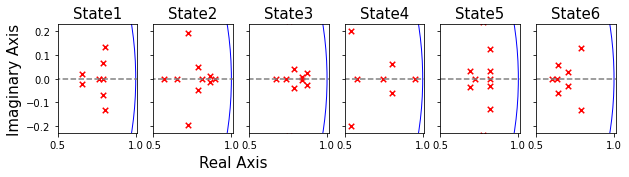

In [13]:
fig, axs = plt.subplots(nrows=1,ncols=K,figsize=(10,2),sharex=True,sharey=True)
for idx_state in range(K):
    ax = axs[idx_state]
    A = As[idx_state]
    lam,_ = np.linalg.eig(A)
    real,imag = np.real(lam),np.imag(lam)
    
    ax.scatter(real,imag,s=30,marker='x',color='r',alpha=1)
    ax.add_patch(patches.Circle((0,0),1,color='blue',fill=False))
    ax.axhline(xmin=-2,xmax=2,y=0,color='grey',linestyle='--')
    # ax.set_title(f'state {idx_state+1}',fontsize=15)
    ax.set_title(f'{state_names[idx_state]}',fontsize=15)
    ax.set_xlim([0.5,1.01])
    ax.set_ylim([-0.23,0.23])
    if idx_state==1: 
        ax.set_xlabel('Real Axis',fontsize=15)
        ax.xaxis.set_label_coords(1.0,-0.2)
    if idx_state==0: ax.set_ylabel('Imaginary Axis',fontsize=15)

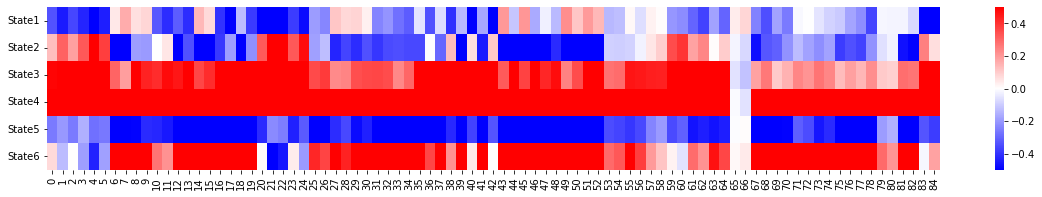

In [14]:
import numpy as np
from scipy.linalg import block_diag

attractor_y = np.zeros((K, N))
attractor_x = np.zeros((K, D))

state_imgs = [None]*K
for idx_state in range(K):
    A = As[idx_state]
    b = bs[idx_state]
    x_bar = np.linalg.inv(np.eye(A.shape[0])-A)@b
    attractor_x[idx_state,:] = x_bar
    y_bar = np.expand_dims(C @ x_bar + d,axis=0)
    attractor_y[idx_state,:] = y_bar

fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot()
_ = sns.heatmap(attractor_y[:,:], cmap='bwr',ax=ax, vmin=-0.5,vmax=0.5,cbar=True)
_ = ax.set_yticklabels(state_names,rotation=0)

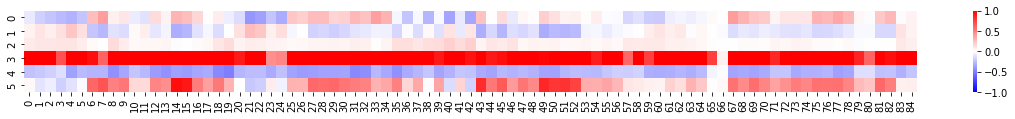

In [15]:
all_states = np.hstack(list(df['discrete_states'].values))
all_ts = np.vstack(list(df['timeseries'].values))
mean_BOLD_true = np.zeros((K,N))
for idx_state in range(K):
    mean_BOLD_true[idx_state,:] = all_ts[all_states==idx_state,:].mean(axis=0)

fig = plt.figure(figsize=(20,1.5))
ax = fig.add_subplot()
_ = sns.heatmap(mean_BOLD_true, cmap='bwr', vmin=-1, vmax=1, ax=ax, cbar=True)

<bound method Figure.tight_layout of <Figure size 1080x1440 with 12 Axes>>

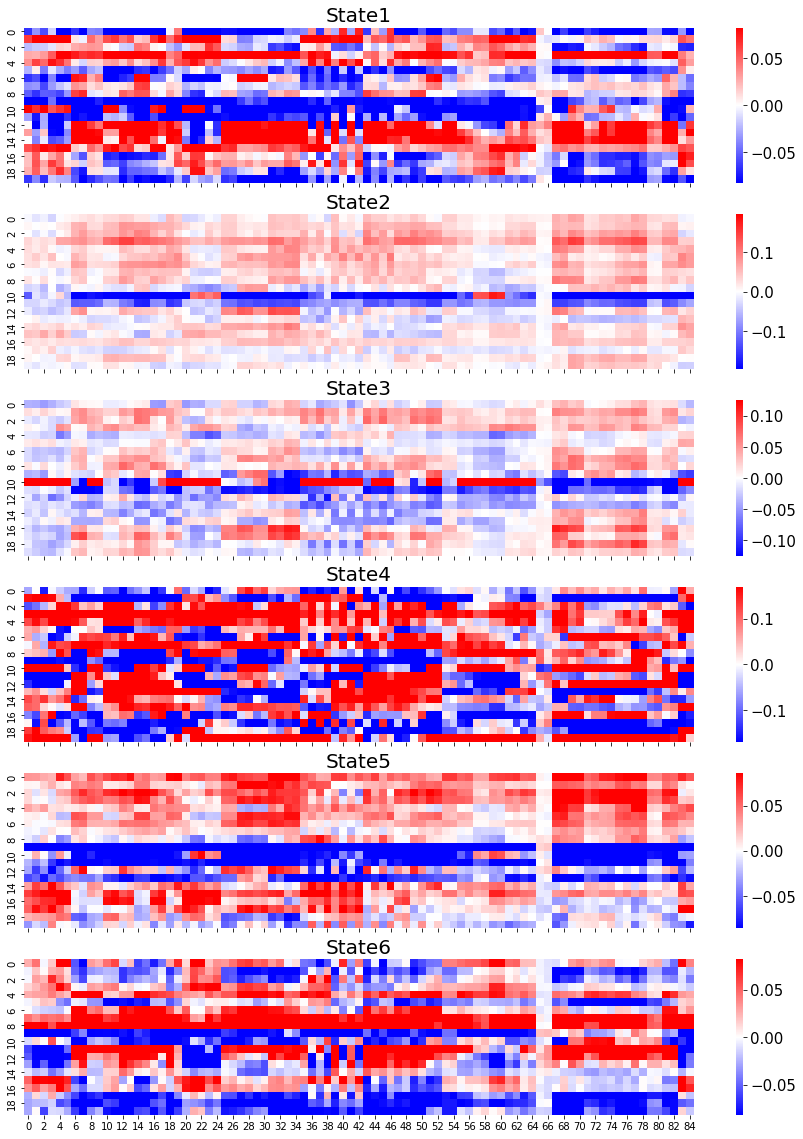

In [16]:
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
yticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        yticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,axs = plt.subplots(nrows=K, ncols=1, figsize=(15,20),sharex=True)
for idx_state in range(K):
    ax = axs[idx_state]
    lim = np.max(np.abs(C@Vs[idx_state]))/5
    _ = sns.heatmap((C@Vs[idx_state]).T, cmap='bwr', ax=ax, cbar=True, vmin=-lim, vmax=lim)
    ax.set_title(f"{state_names[idx_state]}",fontsize=20)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
fig.tight_layout

ValueError: need at least one array to concatenate

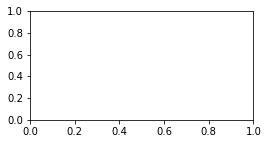

In [17]:
from scipy.stats import linregress
from scipy.stats import ttest_1samp

fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(4,2),sharex=True,sharey=True)
slope_cols = ['Slope','State','Run']
slope_data = {col:[] for col in slope_cols}
for idx_state in range(K):
    ds,ts,slopes = [],[],[]
    for idx_row in range(1,df.shape[0]):
        rid = df.loc[idx_row]['rid']
        z = df.loc[idx_row]['discrete_states']
        x = df.loc[idx_row]['continuous_states']
        # use = df.loc[idx_row]['use']
        # z[use==0] = -1

        idx_begin = list(np.where((z[:-1]!=idx_state)&(z[1:]==idx_state))[0]+1)
        idx_end = list(np.where((z[:-1]==idx_state)&(z[1:]!=idx_state))[0])
        if z[0] == idx_state: idx_begin = [0] + idx_begin
        if z[-1] == idx_state: idx_end = idx_end + [len(z)-1]
        for st,en in zip(idx_begin,idx_end):
            if en-st<1: continue
            d_win = np.linalg.norm(x[st:en+1]-attractor_x[idx_state:idx_state+1,:],axis=1)
            t = np.arange(len(d_win))
            
            ds.append(d_win)
            ts.append(t)
            
            line = linregress(x=t,y=d_win,alternative='less')
            slope_data['Slope'].append(line.slope)
            slope_data['State'].append(state_names[idx_state].strip('State'))
            slope_data['Run'].append(rid)
            

    ds = np.hstack(ds)
    ts = np.hstack(ts)

slope_df = pd.DataFrame(data=slope_data)
ax = axs
sns.kdeplot(
    data=slope_df,
    x='Slope',hue='State',
    ax=ax,
    fill=True,
    palette=sns.color_palette('tab10')
    # y='state',color='grey',
    # estimator=np.mean,
    # errorbar=('ci',95),
    # n_boot=1000
)
ax.axvline(x=0,ymin=0,ymax=1,linewidth=1.5,color='k',linestyle='--')
ax.set_yticks(0.1*np.arange(3))
ax.set_xticks(np.arange(-6,3))
ax.tick_params('both',labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')
ax.set_xlim([-3,3.5])
ax.set_xlabel('Slope of $d_t$\nconvergent behavior $\longleftarrow$ $\longrightarrow$ divergent behavior',fontsize=15)
ax.set_ylabel('Density',fontsize=15)

In [ ]:
import matplotlib
def shift_cmap(cmap, frac):
    """Shifts a colormap by a certain fraction.

    Keyword arguments:
    cmap -- the colormap to be shifted. Can be a colormap name or a Colormap object
    frac -- the fraction of the colorbar by which to shift (must be between 0 and 1)
    """
    N=256
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    n = cmap.name
    x = np.linspace(0,1,N)
    out = np.roll(x, int(N*frac))
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(f'{n}_s', cmap(out))
    return new_cmap
cmap1 = plt.get_cmap('bwr')
cmap2 = shift_cmap(cmap1, 0.5)

In [ ]:
def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_input_contribution(df,model,prob=False,shuffle_z=False):
    # attractor_y = np.zeros((K, N))
    attractor_x = np.zeros((K, D))

    As = model.dynamics.As
    bs = model.dynamics.bs
    Vs = model.dynamics.Vs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]

    x_all = np.vstack(list(df['continuous_states'].values))
    z_all = np.hstack(list(df['discrete_states'].values))
    for idx_state in range(K):
        # A = As[idx_state]
        # b = bs[idx_state]
        # x_bar = np.linalg.inv(np.eye(A.shape[0])-A)@b
        # attractor_x[idx_state,:] = x_bar
        # y_bar = np.expand_dims(C @ x_bar + d,axis=0)
        # attractor_y[idx_state,:] = y_bar
        attractor_x[idx_state,:] = x_all[z_all==idx_state,:].mean(axis=0)

    prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1

    orient_data = {col:[] for col in ['state','stim','cosine']}
    for idx_row in range(df.shape[0]):
        zs = df.loc[idx_row]['discrete_states'].copy()
        xs = df.loc[idx_row]['continuous_states'].copy()
        prox = df.loc[idx_row]['proximity']
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_categories = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        shift = 3
        stim_categories = np.roll(stim_categories,shift=shift)[shift:]
        zs = zs[shift:]
        xs = xs[shift:,:]
        if shuffle_z: zs = np.roll(zs,shift=np.random.randint(len(zs)))

        for z,x,stim in zip(zs,xs,stim_categories):
            dx = attractor_x[z]-x
            v = Vs[z][:,stim]
            sim = cosine(dx,v)
            orient_data['state'].append(z)
            orient_data['stim'].append(stim)
            if prob: orient_data['cosine'].append(1)
            else: orient_data['cosine'].append(sim)

    orient_df = pd.DataFrame(orient_data)

    orient_mat = np.zeros((K,nprox*ndir))
    for idx_state in range(K):
        for idx_stim in range(nprox*ndir):
            orient_vals = orient_df[(orient_df.state==idx_state)&(orient_df.stim==idx_stim)].cosine.values
            if len(orient_vals)>0:
                if prob: orient_mat[idx_state,idx_stim] = np.sum(orient_vals)
                else: orient_mat[idx_state,idx_stim] = np.mean(orient_vals)
    
    if prob: orient_mat /= np.expand_dims(np.sum(orient_mat,axis=1),axis=1)

    return orient_mat

true_mat = get_input_contribution(df, model, prob=True, shuffle_z=False)
num_null = 100
null_mats = np.zeros((num_null,K,nprox*ndir))
for i in tqdm(range(num_null)):
    null_mats[i,:,:] = get_input_contribution(df, model, prob=True, shuffle_z=True)


100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


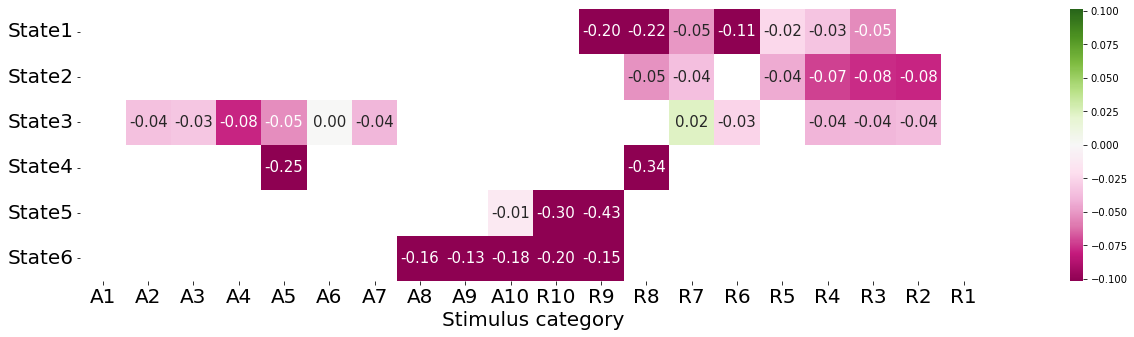

In [ ]:
orient_mat = get_input_contribution(df,model)
pvals = np.zeros_like(true_mat)
for i in range(K):
    for j in range(nprox*ndir):
        pvals[i,j] = (null_mats[:,i,j]>true_mat[i,j]).sum()/num_null
        if pvals[i,j] > 0.05/(K*nprox*ndir):
            orient_mat[i,j] = np.nan

xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
sns.heatmap(
    orient_mat,
    annot=orient_mat, fmt='.2f', annot_kws={'size': 15},
    cmap="PiYG",
    vmin=-(np.abs(true_mat).max()),vmax=(np.abs(true_mat).max()),
    ax=ax,
    cbar=True,
    square=True,
)
_ = ax.set_yticklabels([f'State{i}' for i in range(1,K+1)], fontsize=20, rotation=0)
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
_ = ax.set_xlabel('Stimulus category',fontsize=20)

In [ ]:
def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_input_contribution_trans(df,model,prob=False,shuffle_z=False):
    # attractor_y = np.zeros((K, N))
    attractor_x = np.zeros((K, D))

    As = model.dynamics.As
    bs = model.dynamics.bs
    Vs = model.dynamics.Vs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]

    x_all = np.vstack(list(df['continuous_states'].values))
    z_all = np.hstack(list(df['discrete_states'].values))
    for idx_state in range(K):
        # A = As[idx_state]
        # b = bs[idx_state]
        # x_bar = np.linalg.inv(np.eye(A.shape[0])-A)@b
        # attractor_x[idx_state,:] = x_bar
        # y_bar = np.expand_dims(C @ x_bar + d,axis=0)
        # attractor_y[idx_state,:] = y_bar
        attractor_x[idx_state,:] = x_all[z_all==idx_state,:].mean(axis=0)

    prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1

    trans_orient_data = {col:[] for col in ['state_trans','stim','cosine']}
    for idx_row in range(df.shape[0]):
        zs = df.loc[idx_row]['discrete_states'].copy()
        xs = df.loc[idx_row]['continuous_states'].copy()
        prox = df.loc[idx_row]['proximity']
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_categories = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        shift = 3
        stim_categories = np.roll(stim_categories,shift=shift)[shift:]
        zs = zs[shift:]
        xs = xs[shift:,:]
        if shuffle_z: zs = np.roll(zs,shift=np.random.randint(len(zs)))
        for z,z_prev,x,x_prev,stim in zip(zs[1:],zs[:-1],xs[1:],xs[:-1],stim_categories[1:]):
            if z==z_prev: continue
            dx = attractor_x[z]-x_prev#attractor_x[z_prev]
            v = Vs[z][:,stim]
            sim = cosine(dx,v)
            trans_orient_data['state_trans'].append(f'{z_prev}{z}')
            trans_orient_data['stim'].append(stim)
            if prob: trans_orient_data['cosine'].append(1.0)
            else: trans_orient_data['cosine'].append(sim)

    trans_orient_df = pd.DataFrame(trans_orient_data)

    trans_list = significant_transitions
    trans_orient_mat = np.zeros((len(trans_list),nprox*ndir))
    for idx_trans,trans in enumerate(trans_list):
        for idx_stim in range(nprox*ndir):
            orient_vals = trans_orient_df[(trans_orient_df.state_trans==trans)&(trans_orient_df.stim==idx_stim)].cosine.values
            if len(orient_vals)>0:
                if prob: trans_orient_mat[idx_trans,idx_stim] = np.sum(orient_vals)
                else: trans_orient_mat[idx_trans,idx_stim] = np.mean(orient_vals)
    
    if prob: trans_orient_mat /= np.expand_dims(np.sum(trans_orient_mat,axis=1),axis=1)
    
    return trans_orient_mat

true_mat = get_input_contribution_trans(df, model, prob=True, shuffle_z=False)
num_null = 100
null_mats = np.zeros((num_null,len(significant_transitions),nprox*ndir))
for i in tqdm(range(num_null)):
    null_mats[i,:,:] = get_input_contribution_trans(df, model, prob=True, shuffle_z=True)

100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


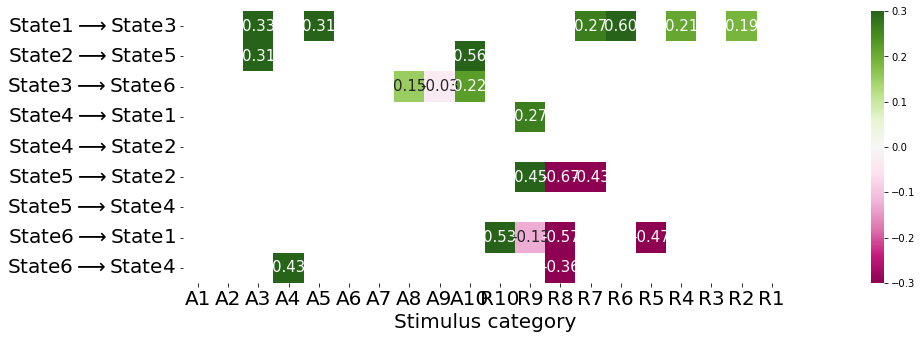

In [ ]:
orient_mat = get_input_contribution_trans(df,model)
pvals = np.zeros_like(true_mat)
for i in range(len(significant_transitions)):
    for j in range(nprox*ndir):
        pvals[i,j] = (null_mats[:,i,j]>true_mat[i,j]).sum()/num_null
        if pvals[i,j] > 0.05/(len(significant_transitions)*nprox*ndir):
            orient_mat[i,j] = np.nan
from scipy.stats import ttest_1samp

xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,5), sharex=True)
sns.heatmap(
    orient_mat,
    annot=orient_mat, fmt='.2f', annot_kws={'size': 15},
    cmap="PiYG",
    vmin=-0.3,vmax=0.3,
    ax=ax,
    cbar=True,
    square=True,
)
# for i in range(K):
#     for j in range(nprox*ndir):
#         vals = orient_mats[:,i,j]
#         pval = ttest_1samp(vals,0,alternative='two-sided').pvalue
#         if pval<0.05:
#             ax.add_patch(
#                 patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='k',facecolor='none')
#             )
# ax.set_title(r'P(State|Stimulus)',fontsize=20) 
_ = ax.set_yticklabels([f'State{int(s[0])+1}$\longrightarrow$State{int(s[1])+1}' for s in trans_list], fontsize=20, rotation=0)
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
_ = ax.set_xlabel('Stimulus category',fontsize=20)